In [1]:
import numpy as np
import hFEMs as hs
import importlib
importlib.reload(hs);
# dir(hs)

In [ ]:
pairs = [(0,9),(1,8)]
CL = np.array([[1,0,0,0,0,0,0,0,0,0]],dtype=np.float)
dL = np.array([42],dtype=np.float)
ndof = 10
lengths = [1,2,3,4,5,6,7,8,9]
solvable = hs.TestSolvable(ndof, lengths, pairs, CL, dL)
print(solvable.grad(np.zeros(10,)))
ns = hs.NewtonSolver(solvable)



In [1]:
# TO GRADIENT TESTING MODULE

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def test_gradients(fun_val, fun_grad, q, dq, eps):
    fL = fun_val(q - eps * dq)
    fR = fun_val(q + eps * dq)
    dfdq = fun_grad(q)
    err = (fR - fL) - (2*eps * dfdq@dq)
    err = np.abs(err)
    return err.min(), err.max()

def test_gradients_O2(fun_val, fun_grad, q, dq, eps):
    fL = fun_val(q)
    fR = fun_val(q + eps * dq)
    dfdq = fun_grad(q)
    err = (fR - fL) - (eps * dfdq@dq)
    err = np.abs(err)
    return err.min(), err.max()

def plot_err(fun_val, fun_grad, ndims, epss, nvals=1, ndirs=1,xscale=1,O2=False):
    errfun = test_gradients_O2 if O2 else test_gradients
    
    errs_min = np.empty((len(epss)),dtype=np.float)
    errs_max = np.empty((len(epss)),dtype=np.float)
    for k,eps in enumerate(epss):
        errmin = np.inf
        errmax = -np.inf
        for j in range(nvals):
            q = np.random.uniform(-xscale,xscale,(ndims,))
            for i in range(ndirs):
                dq = np.random.uniform(-1,1,(ndims,))
                dq /= np.linalg.norm(dq)
                errmin_, errmax_ = errfun(fun_val, fun_grad, q, dq, eps)
                errmin = min(errmin, errmin_)
                errmax = max(errmax, errmax_)
        errs_min[k] = errmin
        errs_max[k] = errmax
    
    plt.plot(epss,errs_min,"C0o",label="err min")
    plt.plot(epss,errs_max,"C1.",label="err max")
    plt.plot(epss,epss,"--",label=r"$\varepsilon$")
    plt.plot(epss,epss**2,"--",label=r"$\varepsilon^2$" + ("!" if O2 else ""))
    plt.plot(epss,epss**3,"--",label=r"$\varepsilon^3$" + ("" if O2 else "!"))
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
# gradient checking TestSolvable
pairs = [(0,9),(1,8)]
CL = np.array([[1,0,0,0,0,0,0,0,0,0]],dtype=np.float)
dL = np.array([42],dtype=np.float)
tst = hs.TestSolvable(pairs, CL, dL)

plot_err(tst.val, tst.grad, ndims=10, epss=np.logspace(-10,0,50), ndirs=3)
plot_err(tst.grad, tst.hess, ndims=10, epss=np.logspace(-10,0,50), ndirs=3)

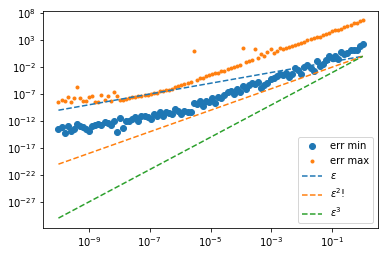

In [5]:
# gradient checking VegaFEMSolvable
import numpy as np
import hFEMs as hs
vegfile = "/home/gsperl/Projects/hFEMs/meshes/testmesh.veg"
strain = np.array([0,0,0, 0,0,0],dtype=np.float)
strain = np.array([0.5,0,0, 0.3,0,0],dtype=np.float)
tst = hs.VegaFEMSolvable(vegfile, strain)

ndof = 315
# plot_err(tst.val, tst.grad, ndims=ndof, epss=np.logspace(-10,0,100), ndirs=3, nvals=3, O2=True)
plot_err(tst.grad, tst.hess, ndims=ndof, epss=np.logspace(-10,0,100), ndirs=3, nvals=3, xscale=0.1, O2=True)


In [20]:
qtst = np.random.uniform(-1,1,ndof)
from scipy.sparse.linalg import norm as sparsenorm
sparsenorm(tst.hess(qtst).transpose() - tst.hess(qtst))

0.0

In [2]:
import numpy as np
import hFEMs as hs

vegfile = "/home/gsperl/Projects/hFEMs/meshes/testmesh.veg"
strain = np.array([0.1,0,0, 0,0,0],dtype=np.float)

solvable = hs.VegaFEMSolvable(vegfile, strain)

nssettings = hs.NewtonSolverSettings()
nssettings.projgrad_epsilon = 0.8
ns = hs.NewtonSolver(solvable, nssettings)

x = solvable.getWorldPositions(ns.getSolution())
nrows,ncols,phi = solvable.getGrid()